Data set taken from here: https://www.kaggle.com/moltean/fruits

# Preperations

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

Set up the GPUs if we can use them.

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    print("Configuring", device)
    tf.config.experimental.set_memory_growth(device, True)

Configuring PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Import our training and test images

In [3]:
IMAGE_SIZE = (100, 100)

train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    vertical_flip=True
)

training_images = train_image_generator.flow_from_directory(
    directory="fruits-360/Training",
    batch_size=32,
    shuffle=True,
    target_size=IMAGE_SIZE
)

test_images = train_image_generator.flow_from_directory(
    directory="fruits-360/Training",
    batch_size=32,
    shuffle=True,
    target_size=IMAGE_SIZE
)

NUM_CLASSES = training_images.num_classes

Found 67692 images belonging to 131 classes.
Found 67692 images belonging to 131 classes.


Show some images from the loaded data set

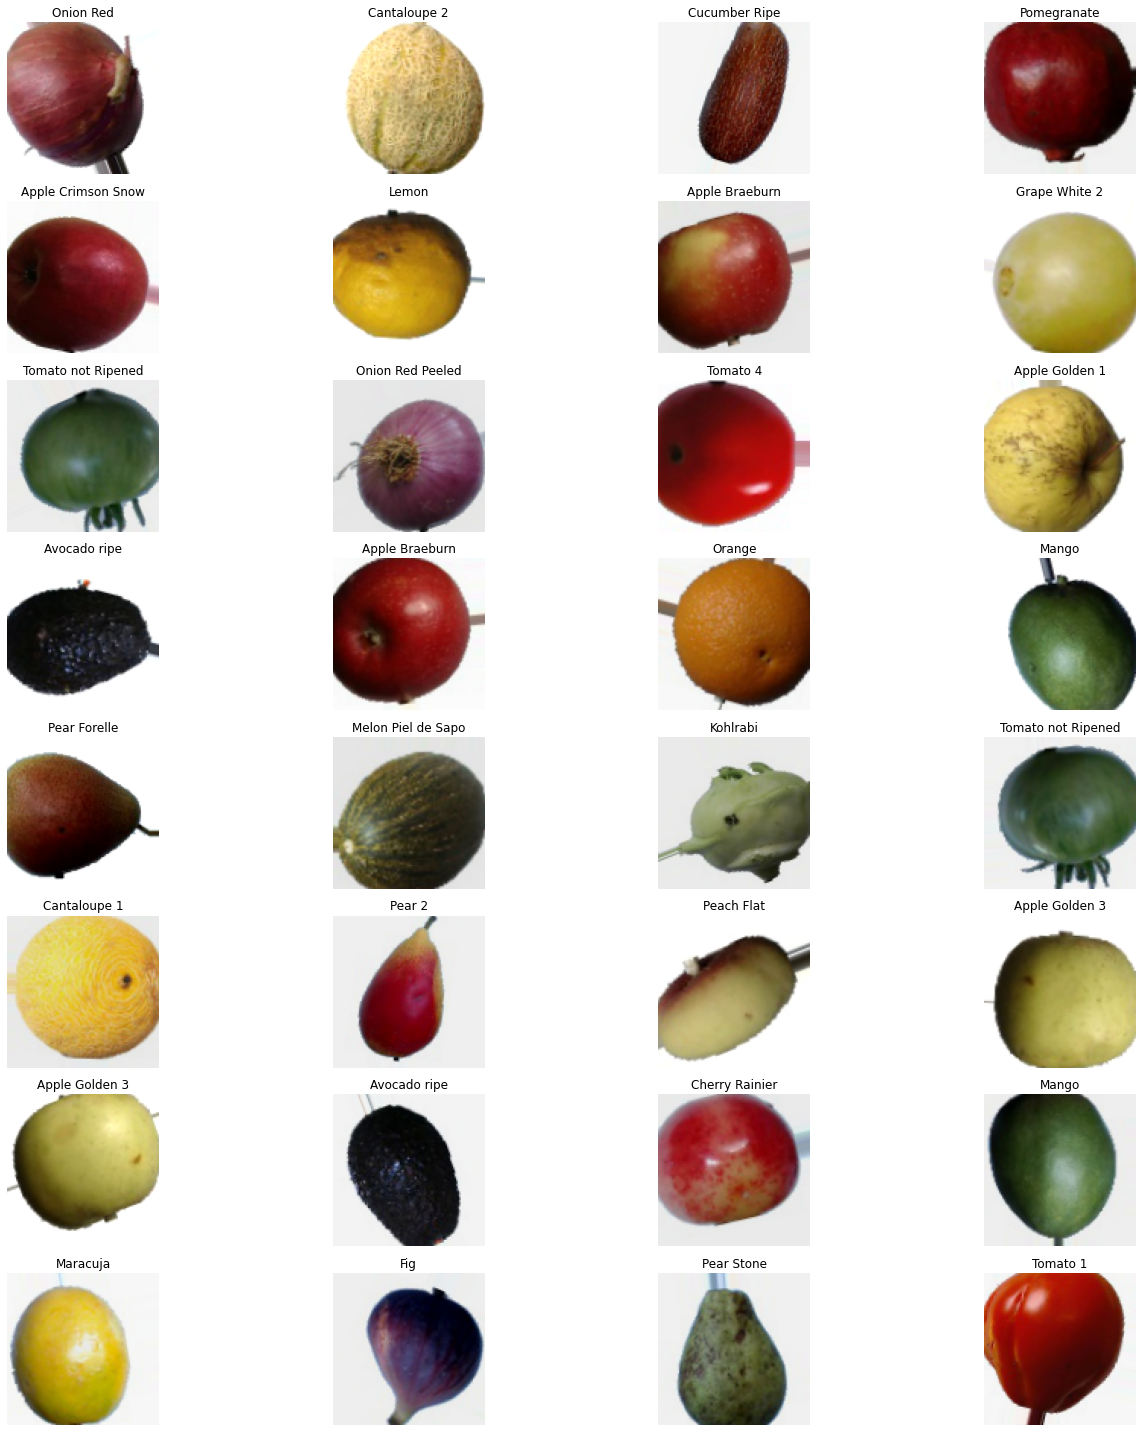

In [4]:
# plt.figure(figsize=(10, 10))
# for images, labels in training_images.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(training_images.class_names[labels[i]])
#         plt.axis("off")
sample_training_images, labels = next(training_images)
class_label = {v:k for k,v in training_images.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

# Neural Network

Create a basic CNN

In [5]:
# This neural net is garbage:
# model = Sequential([
#     #layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMAGE_SIZE + (3,)),
#     layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=IMAGE_SIZE + (3,)),
#     layers.MaxPooling2D(),
#     layers.Conv2D(16, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.2),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(NUM_CLASSES)
# ])

base_model = tf.keras.applications.resnet_v2.ResNet50V2(
    include_top=False,
    pooling='max',
    input_shape=IMAGE_SIZE + (3,),
    weights='imagenet'
)

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(512, 'relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(NUM_CLASSES, 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 131)               33667     
Total params: 24,778,883
Trainable params: 24,733,443
Non-trainable params: 45,440
_________________________________________________________________


Then train the model with the training images.

In [6]:
EPOCHS = 10

Epoch 1/10
2116/2116 [==============================] - 291s 137ms/step - loss: 0.6480 - categorical_accuracy: 0.8207 - val_loss: 0.3391 - val_categorical_accuracy: 0.8959
Epoch 2/10
2116/2116 [==============================] - 277s 131ms/step - loss: 0.2604 - categorical_accuracy: 0.9217 - val_loss: 0.1751 - val_categorical_accuracy: 0.9459
Epoch 3/10
2116/2116 [==============================] - 277s 131ms/step - loss: 0.2152 - categorical_accuracy: 0.9379 - val_loss: 0.1742 - val_categorical_accuracy: 0.9489
Epoch 4/10
2116/2116 [==============================] - 277s 131ms/step - loss: 0.1951 - categorical_accuracy: 0.9459 - val_loss: 0.1779 - val_categorical_accuracy: 0.9490
Epoch 5/10
2116/2116 [==============================] - 279s 132ms/step - loss: 0.1761 - categorical_accuracy: 0.9517 - val_loss: 0.1420 - val_categorical_accuracy: 0.9596
Epoch 6/10
2116/2116 [==============================] - 281s 133ms/step - loss: 0.1656 - categorical_accuracy: 0.9562 - val_loss: 0.1677 - v

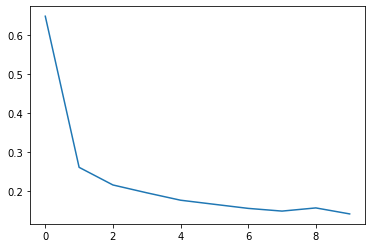

In [7]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

history = model.fit(
    training_images,
    validation_data=test_images,
    epochs=EPOCHS
)

plt.plot(history.history['loss'])

Epoch 1/10
2116/2116 [==============================] - 306s 145ms/step - loss: 1.8471 - categorical_accuracy: 0.5014 - val_loss: 1.2205 - val_categorical_accuracy: 0.6391
Epoch 2/10
2116/2116 [==============================] - 306s 145ms/step - loss: 0.6609 - categorical_accuracy: 0.8117 - val_loss: 6.8058 - val_categorical_accuracy: 0.2310
Epoch 3/10
2116/2116 [==============================] - 297s 140ms/step - loss: 0.6184 - categorical_accuracy: 0.8238 - val_loss: 9.7641 - val_categorical_accuracy: 0.1279
Epoch 4/10
2116/2116 [==============================] - 300s 142ms/step - loss: 0.4255 - categorical_accuracy: 0.8791 - val_loss: 0.5709 - val_categorical_accuracy: 0.8530
Epoch 5/10
2116/2116 [==============================] - 299s 141ms/step - loss: 0.5238 - categorical_accuracy: 0.8525 - val_loss: 0.4262 - val_categorical_accuracy: 0.8641
Epoch 6/10
2116/2116 [==============================] - 322s 152ms/step - loss: 0.4180 - categorical_accuracy: 0.8806 - val_loss: 0.5695 - v

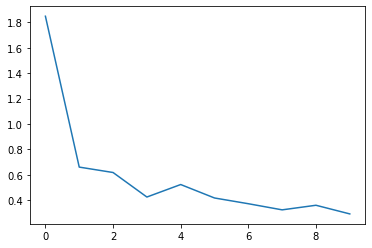

In [8]:
for layer in base_model.layers:
    layer.trainable = True

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

history = model.fit(
    training_images,
    validation_data=test_images,
    epochs=EPOCHS
)

plt.plot(history.history['loss'])

In [9]:
model.save('fruits.h5')

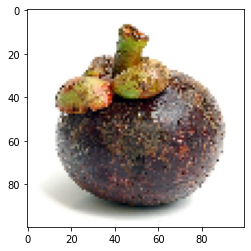

In [35]:
img = tf.keras.preprocessing.image.load_img("fruits-360/mangostan.jpg", target_size=IMAGE_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

plt.imshow(img)

In [39]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
#scores = predictions[0]

classes_reversed = {v: k for k, v in training_images.class_indices.items()}

for i, score in enumerate(scores):
    class_name = classes_reversed[i]
    guesses[class_name] = score

for fruit, score in {k: v for k, v in sorted(guesses.items(), key=lambda item: item[1], reverse=True)}.items():
    pass
    print("{}: {:.2f}%".format(fruit, score * 100))


Banana: 2.43%
Banana Red: 2.19%
Banana Lady Finger: 2.09%
Eggplant: 1.96%
Corn Husk: 1.66%
Corn: 1.46%
Pear Abate: 1.33%
Dates: 1.33%
Pear 2: 1.33%
Grape Blue: 1.28%
Plum 3: 1.27%
Mulberry: 1.27%
Beetroot: 1.24%
Fig: 1.20%
Tomato 2: 1.18%
Nut Pecan: 1.18%
Clementine: 1.13%
Salak: 1.10%
Cucumber Ripe: 1.09%
Pear Stone: 1.09%
Avocado ripe: 1.07%
Cactus fruit: 1.06%
Pear Red: 1.06%
Avocado: 1.06%
Kaki: 1.06%
Pear Forelle: 1.02%
Potato Sweet: 1.01%
Tomato Cherry Red: 0.98%
Strawberry: 0.98%
Potato Red: 0.95%
Blueberry: 0.95%
Cherry 2: 0.94%
Strawberry Wedge: 0.91%
Pitahaya Red: 0.89%
Ginger Root: 0.85%
Tomato 3: 0.85%
Hazelnut: 0.85%
Peach Flat: 0.85%
Chestnut: 0.83%
Pepper Red: 0.83%
Grapefruit Pink: 0.82%
Pear Kaiser: 0.82%
Redcurrant: 0.81%
Potato Red Washed: 0.81%
Tomato 4: 0.79%
Rambutan: 0.79%
Cherry 1: 0.78%
Tomato Heart: 0.77%
Tomato 1: 0.77%
Granadilla: 0.76%
Pepper Green: 0.76%
Papaya: 0.74%
Melon Piel de Sapo: 0.73%
Cherry Rainier: 0.72%
Huckleberry: 0.71%
Apple Braeburn: 0.71%
